In [23]:
import csv

import requests
from bs4 import BeautifulSoup
import io
import pandas as pd

# url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/en/3740566.txt?1624879808?v=1625562924528'
url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/en/3816281.txt?rv3jop'
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 "
                         "Safari/537.36"}

file = open("qs-rank.txt", "w")

path = '/Users/niloy/Desktop/Win10/CodeRepository/Find-Professor-CSRanking/qs-rank.txt'


def get_page(url):
    try:
        r = requests.get(url, headers=headers)
        if r.status_code == 200:
            return r.json()
    except requests.ConnectionError as e:
        print(e)


def parser_page(json):
    if json:
        items = json.get('data')
        for i in range(len(items)):
            item = items[i]
            qsrank = {}
            if "=" in item['rank_display']:
                rk_str = str(item['rank_display']).split('=')[-1]
                qsrank['rank_display'] = rk_str
            else:
                qsrank['rank_display'] = item['rank_display']
            qsrank['logo'] = item['logo']
            qsrank['title'] = BeautifulSoup(item['title'], "html.parser").text
            qsrank['region'] = item['region']
            qsrank['score'] = item['score']



            yield qsrank


def main():
    json = get_page(url)
    results = parser_page(json)
    for result in results:
        with io.open(path, 'a', encoding="utf-8") as f:
            f.write(result['rank_display'] + ';' + 'www.https://www.topuniversities.com' + result['logo'] + ';' + result['title'] + ';' + result['region'] + ';' + result['score'] + '\n')
            f.close()
            print(result)


if __name__ == '__main__':
    print('Started parsing！')
    with io.open(path, 'a', encoding="utf-8") as f:
        f.write('Ranking' + ';' +'logo' + ';' + 'University' + ';' + 'Country' + ';' + 'Score' + '\n')
        f.close()
    main()

    df = pd.read_csv('qs-rank.txt', delimiter=';', header=0)
    df.to_csv('qs-rank.csv', index=False)

    print('Done & Convered to CSV')

Started parsing！
{'rank_display': '1', 'logo': '/sites/default/files/massachusetts-institute-of-technology-mit_410_small.jpg', 'title': 'Massachusetts Institute of Technology (MIT) ', 'region': 'North America', 'score': '100'}
{'rank_display': '2', 'logo': '/sites/default/files/university-of-cambridge_95_small.jpg', 'title': 'University of Cambridge', 'region': 'Europe', 'score': '98.8'}
{'rank_display': '3', 'logo': '/sites/default/files/stanford-university_573_small.jpg', 'title': 'Stanford University', 'region': 'North America', 'score': '98.5'}
{'rank_display': '4', 'logo': '/sites/default/files/university-of-oxford_478_small.jpg', 'title': 'University of Oxford', 'region': 'Europe', 'score': '98.4'}
{'rank_display': '5', 'logo': '/sites/default/files/harvard-university_253_small.jpg', 'title': 'Harvard University', 'region': 'North America', 'score': '97.6'}
{'rank_display': '6', 'logo': '/sites/default/files/california-institute-of-technology-caltech_94_small.jpg', 'title': 'Cali

In [24]:
def visualise_qs_ranking(df, year, top_ranking, num):
    """
    df: dataframe
    top_ranking: top # of universities to be selected
    num: # of countries to be visaulised
    """
    plt.style.use('seaborn-paper')
    top = df.iloc[0:top_ranking]
    
    ax = (top['Country'].value_counts().head(num).plot(
        kind='barh', 
        figsize=(20, 10), 
        color="tab:blue", 
        title="Number of Top {} Universities in QS Ranking {}".format(len(top['Country']), str(year))))
    ax.set_xticks(np.arange(0, top['Country'].value_counts()[0]+2, 1))

In [25]:
df

,Ranking,logo,University,Country,Score
0,1,www.https://www.topuniversities.com/sites/defa...,Massachusetts Institute of Technology (MIT),North America,100.0
1,2,www.https://www.topuniversities.com/sites/defa...,University of Cambridge,Europe,98.8
2,3,www.https://www.topuniversities.com/sites/defa...,Stanford University,North America,98.5
3,4,www.https://www.topuniversities.com/sites/defa...,University of Oxford,Europe,98.4
4,5,www.https://www.topuniversities.com/sites/defa...,Harvard University,North America,97.6
...,...,...,...,...,...
1417,1401+,www.https://www.topuniversities.com/sites/defa...,Universidad Tecnológica de Bolívar,Latin America,NaN
1418,1401+,www.https://www.topuniversities.com/sites/defa...,Universidad de Tarapaca,Latin America,NaN
1419,1401+,www.https://www.topuniversities.com/sites/defa...,University of Craiova,Europe,NaN
1420,1401+,www.https://www.topuniversities.com/sites/defa...,University of Oradea,Europe,NaN


In [41]:
df['rank'] = df['Score'].rank(ascending=False)
df.tail(200)

,Ranking,logo,University,Country,Score,rank
1222,1201-1400,www.https://www.topuniversities.com/sites/defa...,EGE UNIVERSITY,Asia,NaN,NaN
1223,1201-1400,www.https://www.topuniversities.com/sites/defa...,Feng Chia University,Asia,NaN,NaN
1224,1201-1400,www.https://www.topuniversities.com/sites/defa...,Florida Atlantic University - Boca Raton,North America,NaN,NaN
1225,1201-1400,www.https://www.topuniversities.com/sites/defa...,Fu Jen Catholic University,Asia,NaN,NaN
1226,1201-1400,www.https://www.topuniversities.com/sites/defa...,Fundación Universidad de Bogotá Jorge Tadeo Lo...,Latin America,NaN,NaN
...,...,...,...,...,...,...
1417,1401+,www.https://www.topuniversities.com/sites/defa...,Universidad Tecnológica de Bolívar,Latin America,NaN,NaN
1418,1401+,www.https://www.topuniversities.com/sites/defa...,Universidad de Tarapaca,Latin America,NaN,NaN
1419,1401+,www.https://www.topuniversities.com/sites/defa...,University of Craiova,Europe,NaN,NaN
1420,1401+,www.https://www.topuniversities.com/sites/defa...,University of Oradea,Europe,NaN,NaN


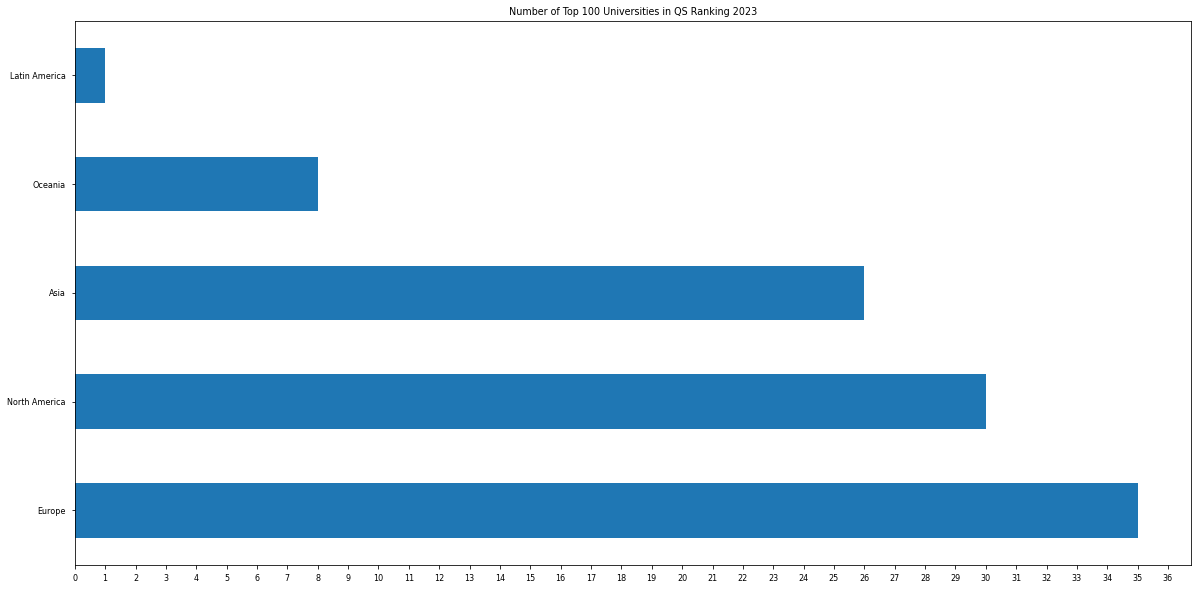

In [26]:
visualise_qs_ranking(df, year=2023, top_ranking=100, num=10)

In [43]:
df[(df["Country"] == "North America") & (df["rank"] <= 100)]

,Ranking,logo,University,Country,Score,rank
0,1,www.https://www.topuniversities.com/sites/defa...,Massachusetts Institute of Technology (MIT),North America,100.0,1.0
2,3,www.https://www.topuniversities.com/sites/defa...,Stanford University,North America,98.5,3.0
4,5,www.https://www.topuniversities.com/sites/defa...,Harvard University,North America,97.6,5.0
5,6,www.https://www.topuniversities.com/sites/defa...,California Institute of Technology (Caltech),North America,97.0,6.5
9,10,www.https://www.topuniversities.com/sites/defa...,University of Chicago,North America,93.2,10.0
12,13,www.https://www.topuniversities.com/sites/defa...,University of Pennsylvania,North America,90.6,13.0
16,16,www.https://www.topuniversities.com/sites/defa...,Princeton University,North America,89.2,16.5
17,18,www.https://www.topuniversities.com/sites/defa...,Yale University,North America,89.0,18.0
19,20,www.https://www.topuniversities.com/sites/defa...,Cornell University,North America,87.2,20.0
21,22,www.https://www.topuniversities.com/sites/defa...,Columbia University,North America,86.7,22.0
